In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [3]:
train_data = pd.read_csv("/kaggle/input/fo-data/train_set (1).csv")
test_data = pd.read_csv("/kaggle/input/fo-data/test_set (1).csv")
val_data = pd.read_csv("/kaggle/input/fo-data/val_set (1).csv")

In [4]:
columns_to_drop = [
    '30min_vsby_km', '1hr_vsby_km', '1.5hr_vsby_km', '2hr_vsby_km', '2.5hr_vsby_km', 
    '6hr_vsby_km', '30min_fog', '1hr_fog', '1.5hr_fog', '2hr_fog',
    '2.5hr_fog', '3hr_fog', '6hr_fog', '30min_fog_type', '1hr_fog_type',
    '1.5hr_fog_type', '2hr_fog_type', '2.5hr_fog_type','3hr_fog_type',
    '6hr_fog_type', '3hr_onset_cond','date_time_IST'
]

In [5]:
train_data = train_data.drop(columns=columns_to_drop)
val_data = val_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [6]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)
val_scaled = scaler.transform(val_data)

In [7]:
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]
X_val, y_val = val_scaled[:, :-1], val_scaled[:, -1]

In [8]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [9]:
rf = RandomForestRegressor(random_state=42)

In [10]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [11]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.7min
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.9min
[CV] END bootstrap=False, max_depth=40, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 5.0min


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.8min
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time= 4.2min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.4min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.4min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.8min
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.0min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.3min


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [12]:
best_rf = random_search.best_estimator_
test_predictions = best_rf.predict(X_test)

In [13]:
y_train_mean = train_data.iloc[:, -1].mean()
y_train_std = train_data.iloc[:, -1].std()

In [14]:
y_test_inv = y_test * y_train_std + y_train_mean
test_predictions_inv = test_predictions * y_train_std + y_train_mean

In [15]:
mse = mean_squared_error(y_test_inv, test_predictions_inv)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MSE: 0.23599235298561894
RMSE: 0.48579044143088995


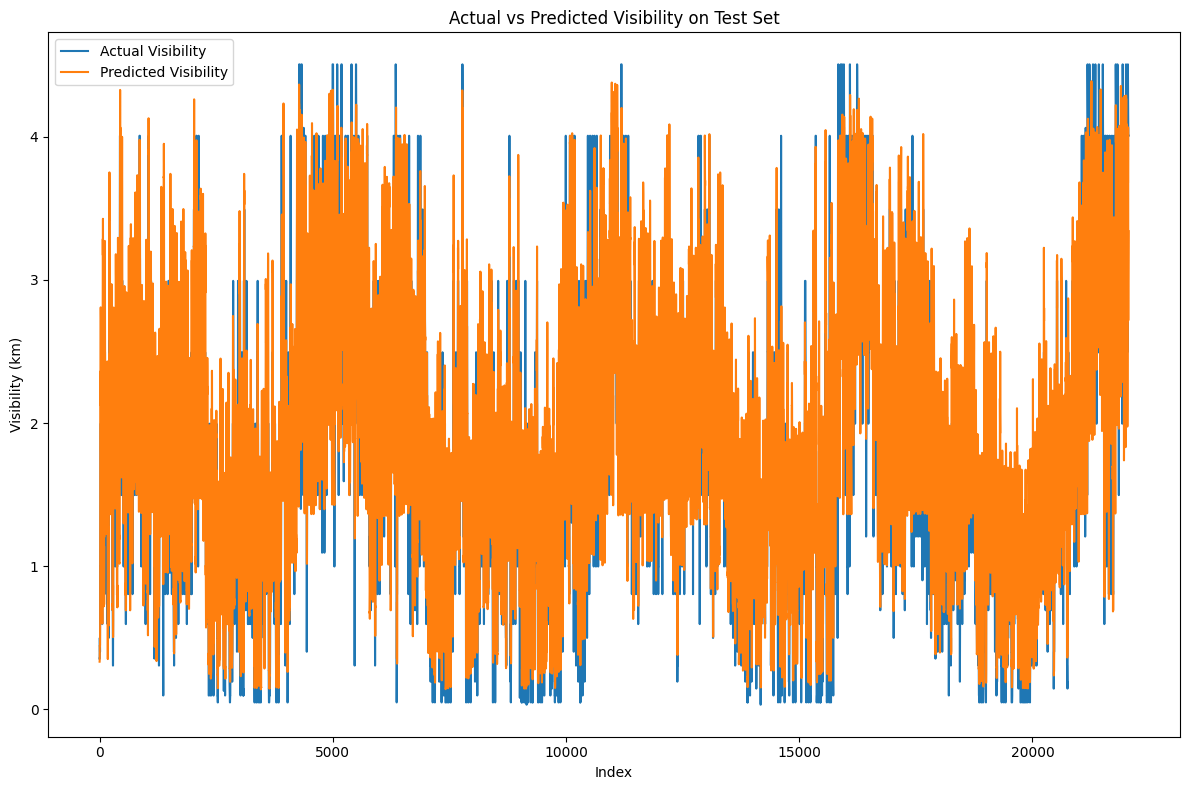

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_inv, label='Actual Visibility')
plt.plot(test_predictions_inv, label='Predicted Visibility')
plt.title('Actual vs Predicted Visibility on Test Set')
plt.xlabel('Index')
plt.ylabel('Visibility (km)')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
current_visibility = y_test_inv[-1]
predicted_next_3hr_visibility = test_predictions_inv[-1]
actual_next_3hr_visibility = y_test_inv[-1]  # Adjust based on your data

print(f'Current Visibility: {current_visibility} km')
print(f'Predicted Visibility for next 3 hours: {predicted_next_3hr_visibility} km')
print(f'Actual Visibility for next 3 hours: {actual_next_3hr_visibility} km')

Current Visibility: 4.007266462894566 km
Predicted Visibility for next 3 hours: 3.340824420627307 km
Actual Visibility for next 3 hours: 4.007266462894566 km
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.9min
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.0min
[CV] END bootstrap=False, max_depth=40, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 5.1min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.0min
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.6min
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.7min
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time= 4.0min
[CV] END bo